# DJGrad Learning Simulation

## Install Packages

In [4]:
!pip install pandas \
             tensorflow \
             matplotlib \
             numpy

## Imports

In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pickle
from itertools import product
from collections import defaultdict
from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen

# Path to this file
fp_local = '/home/jovyan/docker/src/python/temp_test/DJGrad/learning_sim'
fp_out = fp.join(fp_local,'out_data')
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
num_epochs = 4000

## Data Preparation

In [208]:
# Import data from the internet
r = urlopen(url).read()
file = ZipFile(BytesIO(r))
bike = pd.read_csv(file.open("hour.csv"),delimiter=',')
bike = bike.drop(['dteday','instant'],axis=1).sample(frac=1)
bike

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
5762,3,0,9,13,0,5,1,2,0.68,0.64,0.65,0.13,72,207,279
5812,3,0,9,15,0,0,0,1,0.78,0.76,0.66,0.28,218,192,410
4832,3,0,7,6,0,1,1,2,0.72,0.71,0.84,0.09,7,100,107
1447,1,0,3,14,0,6,0,2,0.48,0.47,0.59,0.28,80,118,198
10860,2,1,4,16,0,1,1,1,0.50,0.48,0.34,0.33,104,291,395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16340,4,1,11,14,0,0,0,1,0.40,0.41,0.62,0.30,125,303,428
16362,4,1,11,12,0,1,1,2,0.40,0.41,0.62,0.28,35,207,242
7100,4,0,10,11,0,5,1,1,0.36,0.35,0.50,0.22,40,128,168
512,1,0,1,11,0,0,0,1,0.14,0.14,0.43,0.22,22,77,99


/root/anaconda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


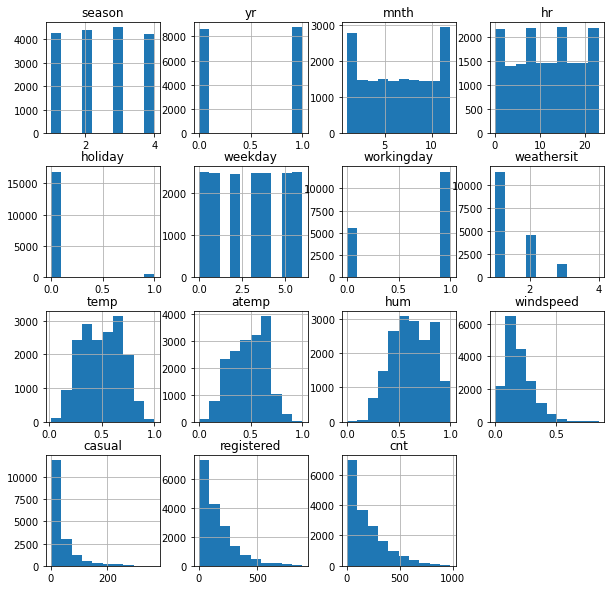

In [5]:
bike.hist(figsize=(10,10))

plt.show()

In [8]:
# Split the dataset into 4 non-iid parts
res = [bike[(bike['hr']>=sr)&(bike['hr']<=so)] for sr,so in zip(range(0,25,6)[:-1],range(-1,24,6)[1:])]

train_dfs = [q.sample(frac=0.8) for q in res]
test_dfs = [q.drop(t.index) for q,t in zip(res,train_dfs)]

In [12]:
# make sure that arrays aren't ragged
min_len = min([x.shape[0] for x in train_dfs])

# Non-iid training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_dfs[0].drop('cnt',axis=1).to_numpy()[:min_len],
    train_dfs[0]['cnt'].to_numpy()[:min_len],
    train_dfs[1].drop('cnt',axis=1).to_numpy()[:min_len],
    train_dfs[1]['cnt'].to_numpy()[:min_len],
    train_dfs[2].drop('cnt',axis=1).to_numpy()[:min_len],
    train_dfs[2]['cnt'].to_numpy()[:min_len],
    train_dfs[3].drop('cnt',axis=1).to_numpy()[:min_len],
    train_dfs[3]['cnt'].to_numpy()[:min_len],
)).shuffle(100).batch(128,True)

# iid testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices((
    np.concatenate((
        test_dfs[0].drop('cnt',axis=1).to_numpy(),
        test_dfs[1].drop('cnt',axis=1).to_numpy(),
        test_dfs[2].drop('cnt',axis=1).to_numpy(),
        test_dfs[3].drop('cnt',axis=1).to_numpy(),
    )),
    np.concatenate((
        test_dfs[0]['cnt'].to_numpy(),
        test_dfs[1]['cnt'].to_numpy(),
        test_dfs[2]['cnt'].to_numpy(),
        test_dfs[3]['cnt'].to_numpy(),
    ))
)).shuffle(100).batch(128,True)

## Definitions

In [9]:
import hashlib
import random

# Defines a class to act as a car in our simulation
class Car():
    def __init__(self,neighbors,p=1.0):
        self.neighbors = neighbors
        self.fwd_q = []
        self.rec_grad = set()
        self.new_grad = []
        self.p = p
        
    # forward gradients to neighbors
    def forward(self,lst_cars,):
        for n,c in enumerate(lst_cars):
            if n in self.neighbors:
                for grad in self.fwd_q:
                    if self.p < random.random():
                        c.receive(grad)
               
    # Specialized forwarding function to forward specific gradients to specific cars
    def forward_each(self, lst_cars, grads):
        assert len(grads)==len(self.neighbors)
        
        for g in grads:
            self._mark_seen(g,True)
            
        for g,c in zip(grads,self.neighbors):
            if self.p < random.random():
                lst_cars[c].load(g)
                lst_cars[c]._mark_seen(g,True)
        
    # Hash function so that we can check to see if a certain gradient has already been received
    def _hash(self,data):
        bts = str(data).encode('utf-8')#tf.io.serialize_tensor(grad)
        return hashlib.sha256(bts).digest()
    
    # Mark a gradient as having been seen so it wont be applied more than once
    def _mark_seen(self,data,hash=False):
        tmp = self._hash(data) if hash else data
        self.rec_grad.add(tmp)
        
    # Checks to see if the gradient has already been seen before
    def already_rec(self,grad,):
        hashed = self._hash(grad)
        
        if hashed in self.rec_grad:
            return (True,hashed)
        else:
            return (False,hashed)
    
    # Applies a list of gradients to a list of tensors and return the result
    def apply_grad(self,grad,hashed,target,):
        self._mark_seen(hashed)
        return [tf.math.add(t,g) for t,g in zip(target,grad)]
    
    # Applies multiple stored gradients to the same tensor
    def apply_grads(self,target,):
        self.fwd_q=[]
        for g in self.new_grad:
            bl,hashed = self.already_rec(g)
            if not bl:
                target = self.apply_grad(g,hashed,target)
                self.fwd_q.append(g)
        self.new_grad=[]
        return target
    
    # Save the gradients to a the incoming queue
    def receive(self,grad,):
        self.new_grad.append(grad)
        
    # Move the gradients to the forwarding queue
    def load(self,grad,):
        self.fwd_q.append(grad)

In [10]:
from tensorflow import keras
from copy import deepcopy
import tensorflow.experimental.numpy as tnp
from sklearn.metrics import confusion_matrix

# Generate a boolen mask to sparify the gradients. We only need a mask because each car only
# shares with two neighbors
def gen_mask(grads,m=2):
    mask = []
    for g in grads:
        if len(g.shape)<2:
            size = 1
        else:
            size = g.shape[0]#[-1]
        assert m%1==0

        if size//2>0: #catches the special case where there's one output
            split = tf.concat([tf.ones(size//m)*i for i in range(m)],0)
            split = tf.random.shuffle(split)
        else:
            split = tf.ones(size) * np.random.randint(0,m)
            
        mask.append(tf.reshape(split,(1,-1)))

    return mask

# Distributed ML class
# Holds the models that will be simulated
class DistMLP(keras.Model):
    def __init__(self,mode='none',p=1.0,both_dir=False):
        super(DistMLP, self).__init__()
        self.mod1 = Sequential([
            layers.Dense(128, activation='sigmoid', input_shape=(14,)),
            layers.Dense(32, activation='sigmoid'),
            layers.Dense(8, activation='sigmoid'),
            layers.Dense(1, 'linear')
        ])
        
        self.mod2 = tf.keras.models.clone_model(self.mod1)
        self.mod2.set_weights(self.mod1.get_weights()) 
        self.mod3 = tf.keras.models.clone_model(self.mod1)
        self.mod3.set_weights(self.mod1.get_weights()) 
        self.mod4 = tf.keras.models.clone_model(self.mod1)
        self.mod4.set_weights(self.mod1.get_weights())
                
        self.mode=mode
        self.both_dir = both_dir
        
        self.p = p
        self.cars = [Car([(i+1)%4,(i-1)%4],p=p) if self.both_dir else Car([(i+1)%4,],p=p) for i in range(4)]
        self.gradients = []

    def call(self, data):
        return self.mod1(data)

    def train_step(self, data):
        x1,y1,x2,y2,x3,y3,x4,y4, = data
        with tf.GradientTape() as tape:
            y_pred1 = self.mod1(x1,training=True)
            y_pred2 = self.mod2(x2,training=True)
            y_pred3 = self.mod3(x3,training=True)
            y_pred4 = self.mod4(x4,training=True)
            loss1 = self.compiled_loss(y1,y_pred1)
            loss2 = self.compiled_loss(y2,y_pred2)
            loss3 = self.compiled_loss(y3,y_pred3)
            loss4 = self.compiled_loss(y4,y_pred4)

        grads = tape.gradient([loss1,loss2,loss3,loss4], self.trainable_weights)
        
        if self.mode=='none':
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            
        elif self.mode=='fed':
            temp = [tf.math.divide(tf.math.add_n([grads[n+i*(len(grads)//4)] for i in range(4)]),4) for n in range(len(grads)//4)]
            self.optimizer.apply_gradients(zip([*temp,*temp,*temp,*temp], self.trainable_weights))
            
        elif self.mode=='djgrad':
            grad_mask = [tf.reshape(m,(-1,)) if len(g.shape)==1 else m for m,g in zip(gen_mask(grads),grads)]
            masked_grads = [tf.math.multiply(tf.transpose(m),g)[0] for m,g in zip(grad_mask,grads)]
        
            if self.both_dir:
                inv_grad_mask = [tf.ones_like(x)-x for x in grad_mask]
                inv_masked_grads = [tf.math.multiply(tf.transpose(m),g)[0] for m,g in zip(inv_grad_mask,grads)]
        
            new_grads = []
                       
            for n,c in enumerate(self.cars):
                i1,i2 = (len(grads)//4)*n,(len(grads)//4)*(n+1)
                new_grads+=c.apply_grads(grads[i1:i2])
                c._mark_seen(masked_grads[i1:i2],True)
                # Sending both ways
                if self.both_dir:
                    c._mark_seen(inv_masked_grads[i1:i2],True)
                    c.forward_each(self.cars,[masked_grads[i1:i2],inv_masked_grads[i1:i2]])
                else:
                    c.forward_each(self.cars,[masked_grads[i1:i2],])
                c.forward(self.cars)
                                     
            self.optimizer.apply_gradients(zip(
                [tf.math.add(g,n) for g,n in zip(grads,new_grads)],
                self.trainable_weights))
        
        for m in self.compiled_metrics._user_metrics:
            m.update_state(tf.concat([y1,y2,y3,y4],0), tf.concat([y_pred1,y_pred2,y_pred3,y_pred4],0),source_array=tf.concat([x1[:,3],x2[:,3],x3[:,3],x4[:,3]],0))

        res = {k.name:k.result() for k in self.compiled_loss.metrics}
    
        res.update({m.name: m.result() for m in self.compiled_metrics._user_metrics})
            
        return res
    
    def test_step(self, data):
        x, y = data
        
        y_pred1 = self.mod1(x,training=False)
        y_pred2 = self.mod2(x,training=False)
        y_pred3 = self.mod3(x,training=False)
        y_pred4 = self.mod4(x,training=False)
                
        self.compiled_loss(tf.concat([y,y,y,y,],0),tf.concat([y_pred1,y_pred2,y_pred3,y_pred4],0))
        for m in self.compiled_metrics._user_metrics:
            m.update_state(tf.concat([y,y,y,y],0),tf.concat([y_pred1,y_pred2,y_pred3,y_pred4],0),source_array=tf.concat([x[:,3],x[:,3],x[:,3],x[:,3]],0))

        return {m.name: m.result() for m in self.compiled_metrics._user_metrics}
    
    def reset_metrics(self):
        for m in self.compiled_metrics._user_metrics:
            m.reset_state()
        for m in self.metrics:
            m.reset_state()
        for m in self.compiled_loss.metrics:
            m.reset_state()

In [11]:
# Custom class-wise metric for evaluating the performance of each class (based on hours)
class CWMet(tf.keras.metrics.Metric):
    def __init__(self, car_idx, minmax, name='classwise_accuracy', num_cars=4, **kwargs):
        super(CWMet, self).__init__(name=name, **kwargs)
        self.num_cars = num_cars
        self.car_idx = car_idx
        self.minmax = minmax
        self.loss = self.add_weight(name='loss',initializer='zeros')
        self.num_samples = self.add_weight(name='num_samples',initializer='zeros')

    def update_state(self, y_true, y_pred, source_array=None, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, (4,-1))[self.car_idx], tf.float32)
        y_pred = tf.cast(tf.reshape(y_pred, (4,-1))[self.car_idx], tf.float32)
        
        if source_array is not None:
            source_array = tf.reshape(source_array, (4,-1))[self.car_idx]

            bl_mask = tf.math.logical_and(
                tf.math.greater_equal(source_array, self.minmax[0]),
                tf.math.greater_equal(self.minmax[1],source_array),
            )
                
            y_true = tf.boolean_mask(y_true, bl_mask)
            y_pred = tf.boolean_mask(y_pred, bl_mask)
            
        loss = tf.math.reduce_sum(tf.math.square(y_true-y_pred))

        count_class = tf.math.reduce_sum(tf.cast(bl_mask,dtype=tf.float32))
        
        self.loss.assign_add(loss)
        self.num_samples.assign_add(count_class)

    def result(self):
        return tf.math.divide_no_nan(self.loss,self.num_samples)

## Independent Models

In [14]:
tf.random.set_seed(0)

m = DistMLP('none')
m.compile(
    optimizer=tf.keras.optimizers.Adam(1*10e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[CWMet(ca,(q1,q2),name=f'ca{ca+1}-[{q1},{q2}]') for ca,(q1,q2) in product(range(4),zip(range(0,25,6)[:-1],range(-1,24,6)[1:]))],
    run_eagerly=True
)

history = defaultdict(list)

In [ ]:
%%time

tmp = m.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset
)

for k in tmp.history:
    history[k]+=tmp.history[k]
    
with open(os.path.join(fp_out,'none.pickle'), 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Federated Learning

In [18]:
tf.random.set_seed(0)

m = DistMLP('fed')
m.compile(
    optimizer=tf.keras.optimizers.Adam(1*10e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[CWMet(ca,(q1,q2),name=f'ca{ca+1}-[{q1},{q2}]') for ca,(q1,q2) in product(range(4),zip(range(0,25,6)[:-1],range(-1,24,6)[1:]))],
    run_eagerly=True
)

history = defaultdict(list)

In [ ]:
%%time    
    
tmp = m.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset
)

for k in tmp.history:
    history[k]+=tmp.history[k]
    
with open(os.path.join(fp_out,'fed.pickle'), 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

## DJGrad, $p=1.0$

In [22]:
tf.random.set_seed(0)

m = DistMLP('djgrad',p=1.0,both_dir=True)
m.compile(
    optimizer=tf.keras.optimizers.Adam(1*10e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[CWMet(ca,(q1,q2),name=f'ca{ca+1}-[{q1},{q2}]') for ca,(q1,q2) in product(range(4),zip(range(0,25,6)[:-1],range(-1,24,6)[1:]))],
    run_eagerly=True
)

history = defaultdict(list)

In [ ]:
%%time

tmp = m.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset
)

for k in tmp.history:
    history[k]+=tmp.history[k]
    
with open(os.path.join(fp_out,'djgrad_100.pickle'), 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

## DJGrad, $p=0.9$

In [27]:
tf.random.set_seed(0)

m = DistMLP('djgrad',p=0.9,both_dir=True)
m.compile(
    optimizer=tf.keras.optimizers.Adam(1*10e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[CWMet(ca,(q1,q2),name=f'ca{ca+1}-[{q1},{q2}]') for ca,(q1,q2) in product(range(4),zip(range(0,25,6)[:-1],range(-1,24,6)[1:]))],
    run_eagerly=True
)

history = defaultdict(list)

In [ ]:
%%time
    
tmp = m.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset
)

for k in tmp.history:
    history[k]+=tmp.history[k]
    
with open(os.path.join(fp_out,'djgrad_090.pickle'), 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Analysis

In [34]:
files = [
    'none',
    'fed',
    'djgrad_100',
    'djgrad_090'
]

hist = []

for f in files:
    with open(os.path.join(fp_out,f'{f}.pickle'), 'rb') as handle:
        hist.append(pickle.load(handle))

### Test Loss at Final Epoch

In [157]:
epoch = 4000
names = ['none','fed','djgrad:1.0','djgrad:0.9']

df = pd.DataFrame(
    list(zip(*[np.sqrt([h[c][epoch-1] for c in h if 'val' in c]) for h in hist])),
    columns=names,
    index=pd.MultiIndex.from_tuples(product(range(1,5),classes),names=['car','hours'])
)

def highlight_min(x, color, n=1):
    return np.where(x == np.partition(x.to_numpy().flatten(), n-1)[n-1], f"background: {color};", None)

df.style.apply(highlight_min, color='lightgreen',n=1,axis=1)\
        .apply(highlight_min, color='yellow',n=2,axis=1)

### P-values

In [143]:
# federated learning
t_hist = [np.sqrt([h[c][epoch-1] for c in h if 'val' in c]).reshape(4,4) for h in [hist[0],hist[1]]]
[(wilcoxon(*z,alternative='less')[1],wilcoxon(*z,alternative='greater')[1]) for z in zip(*t_hist)]

[(0.9375, 0.125), (1.0, 0.0625), (1.0, 0.0625), (1.0, 0.0625)]

In [144]:
# DJGrad(1.0)
t_hist = [np.sqrt([h[c][epoch-1] for c in h if 'val' in c]).reshape(4,4) for h in [hist[0],hist[2]]]
[(wilcoxon(*z,alternative='less')[1],wilcoxon(*z,alternative='greater')[1]) for z in zip(*t_hist)]

[(1.0, 0.0625), (1.0, 0.0625), (0.125, 0.9375), (0.1875, 0.875)]

In [145]:
# DJGrad(0.9)
t_hist = [np.sqrt([h[c][epoch-1] for c in h if 'val' in c]).reshape(4,4) for h in [hist[0],hist[3]]]
[(wilcoxon(*z,alternative='less')[1],wilcoxon(*z,alternative='greater')[1]) for z in zip(*t_hist)]

[(0.9375, 0.125), (1.0, 0.0625), (0.6875, 0.4375), (0.125, 0.9375)]

In [211]:
### Training Plots

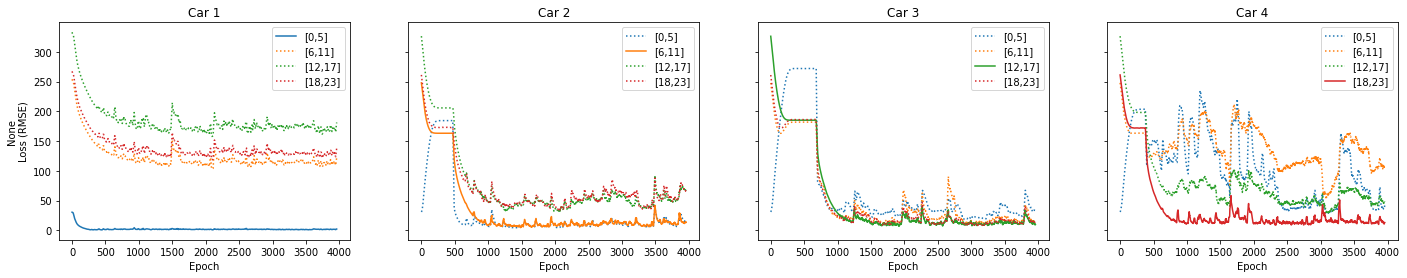

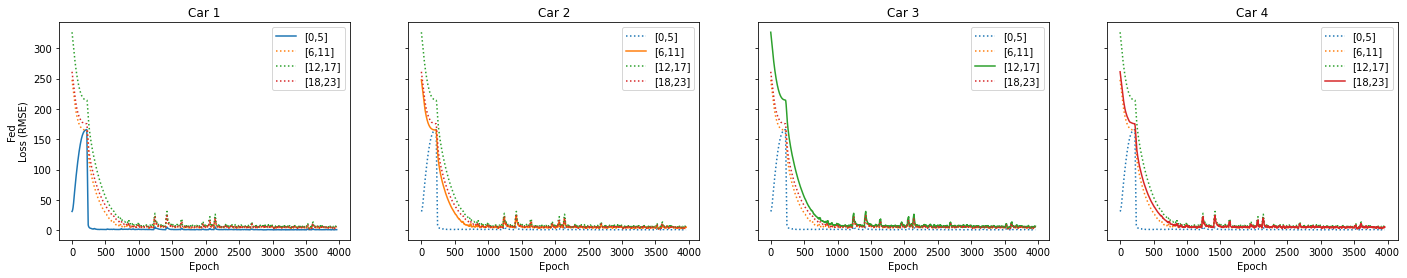

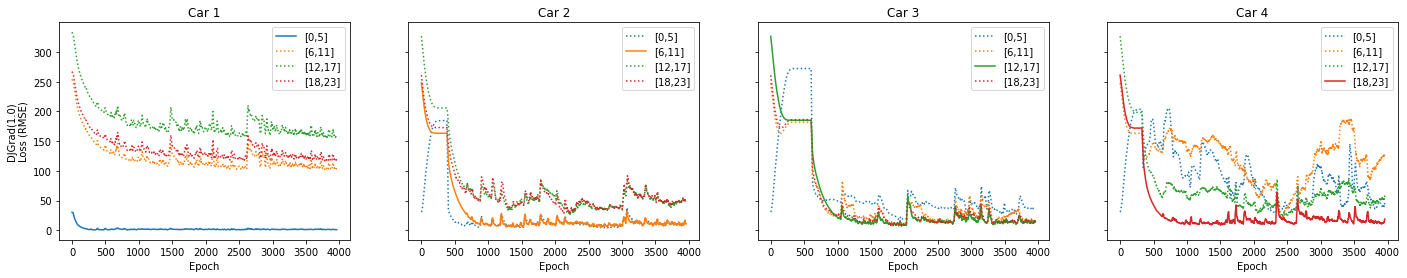

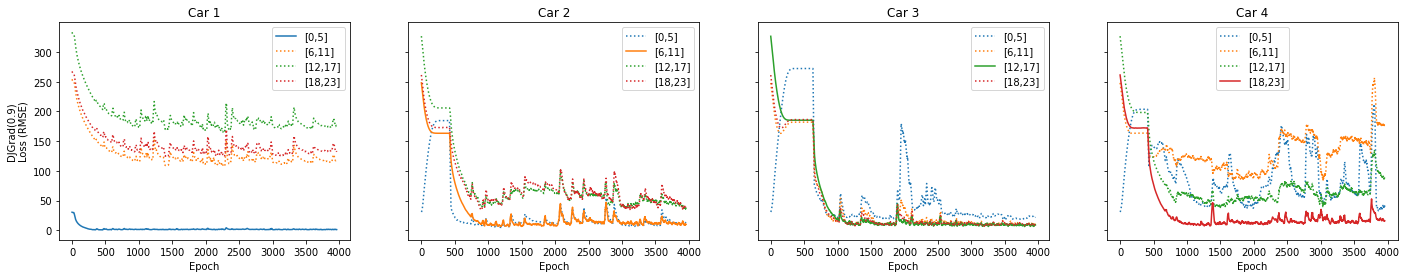

In [191]:
for name,h in zip(['None','Fed','DJGrad(1.0)','DJGrad(0.9)'],hist):
    fig, axs = plt.subplots(1, 4, sharey=True, figsize=(24, 4))

    for n1,ax in enumerate(axs):
        for n2,k in enumerate([k for k in h if f'val_ca{n1+1}' in k]):
            ax.plot(smooth(np.sqrt(h[k][offset:epoch]),20), label=k.split('-')[1],linestyle='-' if n1==n2 else ':')

        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_title(f'Car {n1+1}')
        
    
    
    axs[0].set_ylabel(f"{name}\nLoss (RMSE)")
    plt.show()